# Prepare training and validation data from labeled dataset

In this notebook, we will take the annotated dataset containing Raven-formatted annotation files, and prepare a table of labels that we can use to train a Convolutional Nerual Network (CNN) in OpenSoundscape. The format of the labels we want to create is a table with the audio file path, start and end time of 2-second audio segments (with 1.5 seconds of overlap between segments), and 0 (absent) or 1 (present) labels for each clip and each annotation 'A', 'B', 'C', 'D', 'E', or 'X'. 

To do this, we will use the BoxedAnnotations class in OpenSoundscape to load Raven-formatted annotations and convert them to one-hot labels. 

Then, we'll split our labeled data into training and validation sets for the CNN training phase.


This notebook is part of a series of notebooks and scripts in the [repository](https://github.com/kitzeslab/rana-sierrae-cnn):

- `01_explore_annotated_data.ipynb` Explore annotated dataset of Rana sierrae call types

- `02_prep_training_data.ipynb` Prepare annotated files for training a CNN machine learning model

- `03_train_cnn.ipynb` Train a CNN to recognize Rana sierrae vocaliztaions

- `04_cnn_prediction.ipynb` Use the cnn to detect Rana sierrae in audio recordings

- `05_cnn_validation.ipynb` Analyze the accuracy and performance of the CNN

- `06_aggregate_scores.py` Aggregate scores from CNN prediction across dates and times of day

- `07_explore_results.ipynb` Analyze temporal patterns of vocal activity using the CNN detections


In [1]:
import pandas as pd
from opensoundscape.annotations import BoxedAnnotations
from glob import glob
from pathlib import Path

## Download the dataset
<!-- Running this cell will download the annotated dataset and save it to the same directory as this notebook. 
 -->
 
<!--  %%bash
curl -L https://datadryad.org/stash/downloads/download_resource/0?share=aR1YcRD1JbxzYe3oRLRCHH60_C6QBjWq9lKthC0ODr4 -->


Visit this link to download the dataset:  https://datadryad.org/stash/share/aR1YcRD1JbxzYe3oRLRCHH60_C6QBjWq9lKthC0ODr4

The size of the dataset is approximately 40 Mb. Download time will depend on the speed of your internet connection.

After downloading the data from the link:

(1) unzip the downloaded folder `doi_10.5061_dryad.9s4mw6mn3__v1` (double click or right click->unzip)

(2) unzip the inner folder `rana_sierrae_2022`

(3) change the path in the following cell to the location of the unzipped `rana_seirrae_2022` folder:

In [2]:
data_dir='./rana_sierrae_2022'

The table `audio_and_raven_files.csv` in the dataset pairs each audio file in the dataset with the corresponding annotation file. 

We'll load this table into a DataFrame called `file_df`:

In [3]:
file_df=pd.read_csv(f'{data_dir}/audio_and_raven_files.csv')

## Load Raven annotations using OpenSoundscape

Raven annotations are delimited in time with a start and end time. When creating labels for two-second clips, we will consider a clip to contain the annotation if either (1) at least 0.2 seconds of the annotation overlap with the clip (`min_label_overlap` argument), or (2) more than 50% of the annotation falls within this 2 second clip (`min_label_fraction` parameter). 

In [ ]:
annotation_types = ['A','B','C','D','E','X']
all_annotations = []
for af, rf in zip(file_df.audio,file_df.raven):
    raven_path = f"{data_dir}/{rf}"
    ba = BoxedAnnotations.from_raven_file(raven_path,annotation_column='annotation',audio_file=af) 
    ba.df = ba.df.dropna() 
    # if len(ba.df)>0:
    clip_df = ba.one_hot_clip_labels(
                           class_subset=annotation_types,
                           full_duration=10,
                           clip_duration=2,
                           clip_overlap=1.5,
                           min_label_overlap=0.2,
                           min_label_fraction=0.5,
                        ).astype(int)
    #assert len(clip_df)==17
    #we will add the full path of the audio file for eas of use later
    clip_df['file']=f"{data_dir}/{af}"
    clip_df = clip_df.reset_index().set_index(['file','start_time','end_time'])
    all_annotations.append(clip_df)
labels = pd.concat(all_annotations)

We now have a table of one-hot labels for 2-second audio segments. Let's check the number of clips containing each annotation type:

In [5]:
labels.sum()

A    2678
B     117
C     506
D     355
E     726
X     621
dtype: int64

Let's look at a random selection of 5 rows from our one-hot label dataframe:

In [6]:
labels.sample(5,random_state=2023)

,,,A,B,C,D,E,X
file,start_time,end_time,,,,,,
./rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220622_134500_0-10s.mp3,0.5,2.5,1,0,0,0,0,0
./rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220620_214500_0-10s.mp3,0.0,2.0,0,0,0,0,0,0
./rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220620_050000_0-10s.mp3,8.0,10.0,1,0,0,0,0,0
./rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220621_011500_0-10s.mp3,1.0,3.0,1,0,0,0,0,0
./rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220621_194500_0-10s.mp3,4.0,6.0,0,0,0,0,0,0


## Prepare training data
We want to train a CNN to detect vocalization types A and E. If a 2-second clip has the X (uncertain) label and does not have an A or E label, we will exclude the clip from training and validation (since we are uncertain if it contains the target classes). 

We create a table of 0/1 labels, with 1 for A or E annotations and 0 otherwise. 


In [7]:
import numpy as np
#choose training and validation labels: clips labeled with A or E
labels['rana_sierrae']=np.logical_or(labels.A,labels.E).astype(int)

# drop clips with 0 for rana_sierrae and 1 for 'X' unsure class
labels = labels.drop(labels[(labels['rana_sierrae']==0) & (labels.X==1)].index)

## Split labeled files into train and validation sets

We want to make sure a 10 second file is included entirely in the training or validation set, rather than being split across the two sets. Therefore, we perform a random split on the list of audio files, retaining 10% as validation and using the other 90% for training. 

In [8]:
labels2 = pd.read_csv('./resources/labels_2s.csv')

In [9]:
from sklearn.model_selection import train_test_split

train_files,val_files = train_test_split(labels.reset_index().file.unique(),test_size=0.1,random_state=20221208)

# subset the labels for training and validation based on the file lists
train_df = labels.reset_index().set_index('file').loc[train_files][['start_time','end_time','rana_sierrae']]
val_df = labels.reset_index().set_index('file').loc[val_files][['start_time','end_time','rana_sierrae']]

In [10]:
train_df.to_csv('./resources/training_set.csv')
val_df.to_csv('./resources/validation_set.csv')

# Sanity check: look at a labeled clip

Let's check out the audio and spectrogram of a a clip that contains the label 'E'

In [11]:
from opensoundscape import Audio, Spectrogram
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'
from opensoundscape.annotations import BoxedAnnotations

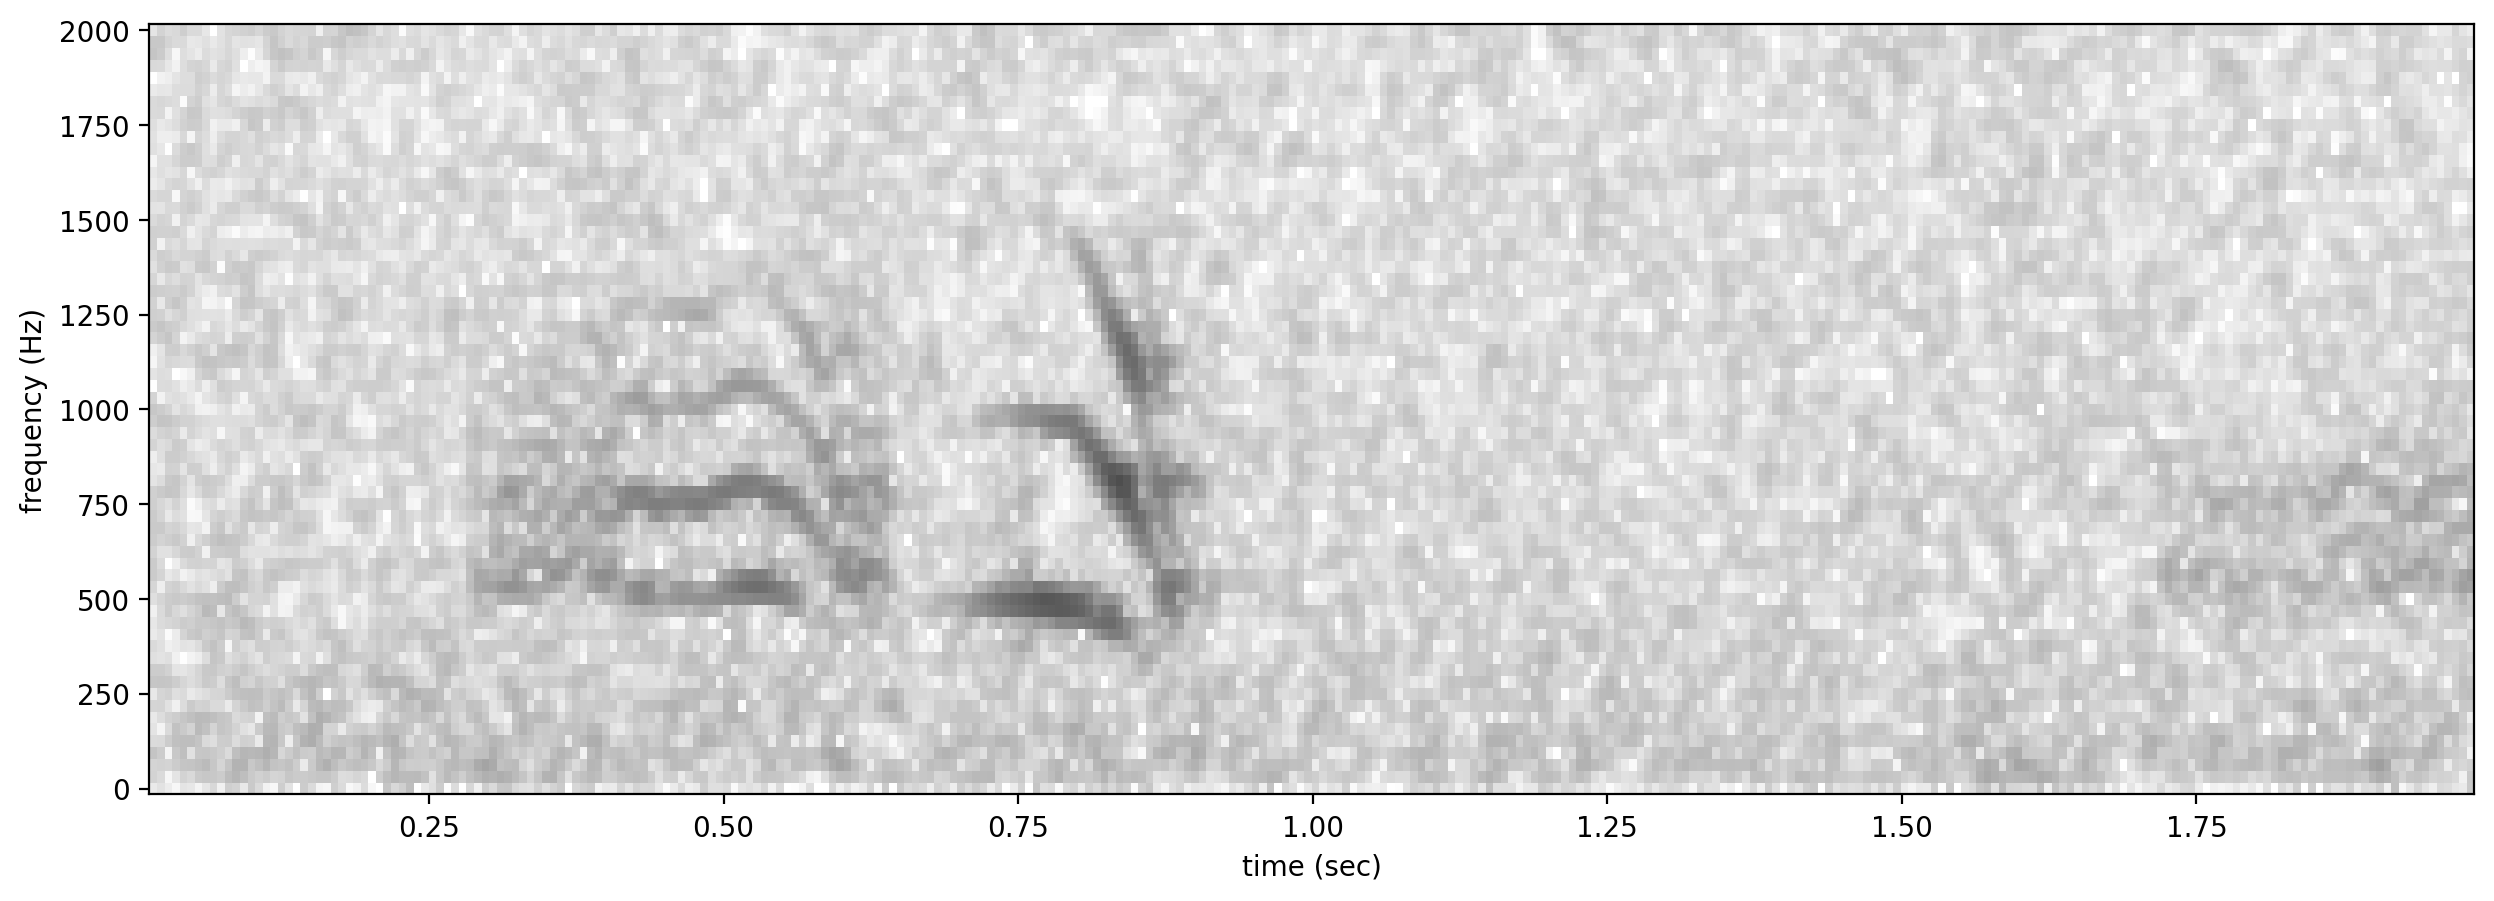

labels:
A               0
B               0
C               0
D               0
E               1
X               0
rana_sierrae    1
Name: (./rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220625_080000_0-10s.mp3, 2.0, 4.0), dtype: int64


In [36]:
row = labels.loc[('./rana_sierrae_2022/mp3/sine2022a_MSD-0558_20220625_080000_0-10s.mp3',2.0,4.0)]
audio_path = row.name[0]
audio=Audio.from_file(audio_path,offset=row.name[1],duration=2)
Spectrogram.from_audio(audio,window_samples=1024,overlap_fraction=0.8).bandpass(0,2000).plot()
print('labels:')
print(random_row)